# Eccentricity Analysis

In [1]:
import numpy as np
import femagtools
import logging
import matplotlib.pyplot as plt

In [2]:
machine1 = {
    'name': 'IPM-4',
    'dxffile':{'name':'IPM4.dxf', 'plot': True},
    'lfe': 0.1,
    'stator': {'mcvkey_yoke':'M400-50A'},
    'magnet': {'mcvkey_yoke':'M400-50A'},
    'winding': {'num_phases':3, 'num_layers': 1, 'num_wires':10, 'coil_span':3,
                'num_par_wdgs': 1,
               'fillfac':0.42, 'culength':1.6}
}

In [3]:
import pathlib
workdir = pathlib.Path('ipm')
workdir.mkdir(exist_ok=True)
femag = femagtools.Femag(workdir, magnetizingCurves='.')

In [4]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(message)s')

2024-06-09 19:13:24,001 search file M400-50A.MCV in /home/tar/femag/VEM
2024-06-09 19:13:24,002 search file M400-50A.MCV in /home/tar/femag/VEM
2024-06-09 19:13:24,002 Copy file M400-50A.MCV
2024-06-09 19:13:24,003 create new model 'IPM-4'
2024-06-09 19:13:24,088 ***** start processing IPM4 *****
2024-06-09 19:13:25,140 total elements 292
2024-06-09 19:13:25,201 check for full machine
2024-06-09 19:13:25,218  - it is full
2024-06-09 19:13:25,668 === airgap is 34.25 ===
2024-06-09 19:13:25,994 *** Begin symmetry search for inner ***
2024-06-09 19:13:26,057  - inner: symmetry axis found
2024-06-09 19:13:26,967 *** End of symmetry search for inner (symmetry and mirror) ***
2024-06-09 19:13:26,968 *** Begin symmetry search for outer ***
2024-06-09 19:13:27,255  - outer: symmetry axis found
2024-06-09 19:13:31,440 *** End of symmetry search for outer (symmetry and mirror) ***
2024-06-09 19:13:31,749 ***** END of work: IPM4 *****


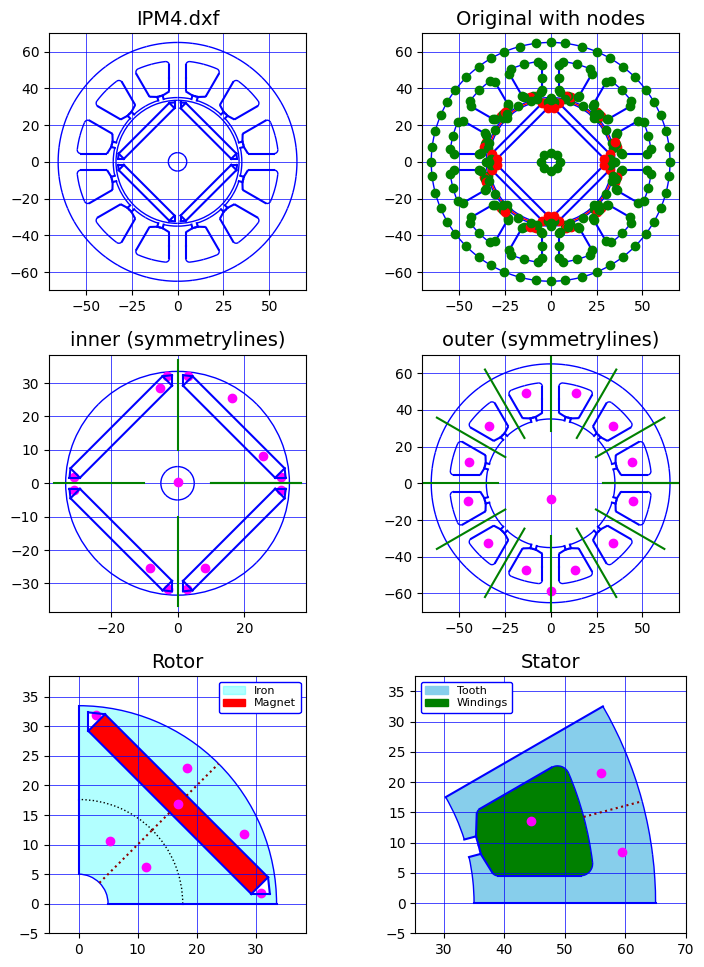

2024-06-09 19:13:32,444 Num nodes/p 96 Num nodes/slot 32 nodedist 1
2024-06-09 19:13:32,563 -- all done in 8.4752 seconds --
2024-06-09 19:13:32,564  num poles 4 num slots 12 outer diameter 0.1300 m
2024-06-09 19:13:32,580 invoking /home/tar/bin/xfemag64 -b femag.fsl
2024-06-09 19:13:32,597  > FSL...exe "femag.fsl"
2024-06-09 19:13:32,597  > New model "IPM-4", ""
2024-06-09 19:13:33,953  > Save model and continue
2024-06-09 19:13:33,971  > FSL...halt
2024-06-09 19:13:33,976 /home/tar/bin/xfemag64 exited with returncode 0 (num errs=0)


In [5]:
r = femag(machine1)

Calculate current angles (D axis) and move steps

In [6]:
machine1.update({k: r['model'][k] for k in r['model'] if k != 'stator'})
simulation = {
    "error_perm": 0.05,
    "angl_i_up": 0.0,
    "calculationMode": "cogg_calc",
    "eval_force": 1,
    "magn_temp": 20,
    "speed": 4000/60,
    "period_frac": 6,
    "num_par_wdgs": machine1['winding']['num_par_wdgs']
}
r = femag({'name': machine1['name'], 'poles':machine1['poles']}, simulation)

2024-06-09 19:13:33,980 Poc file IPM-4_4p.poc
2024-06-09 19:13:33,988 create simulation 'cogg_calc'
2024-06-09 19:13:33,992 invoking /home/tar/bin/xfemag64 -b femag.fsl
2024-06-09 19:13:34,008  > FSL...exe "femag.fsl"
2024-06-09 19:13:39,920  > Load model "IPM-4"Save model and close files
2024-06-09 19:13:39,957  > FSL...halt
2024-06-09 19:13:39,964 /home/tar/bin/xfemag64 exited with returncode 0 (num errs=0)
2024-06-09 19:13:39,965 Read BCH ipm/IPM-4_047.BATCH


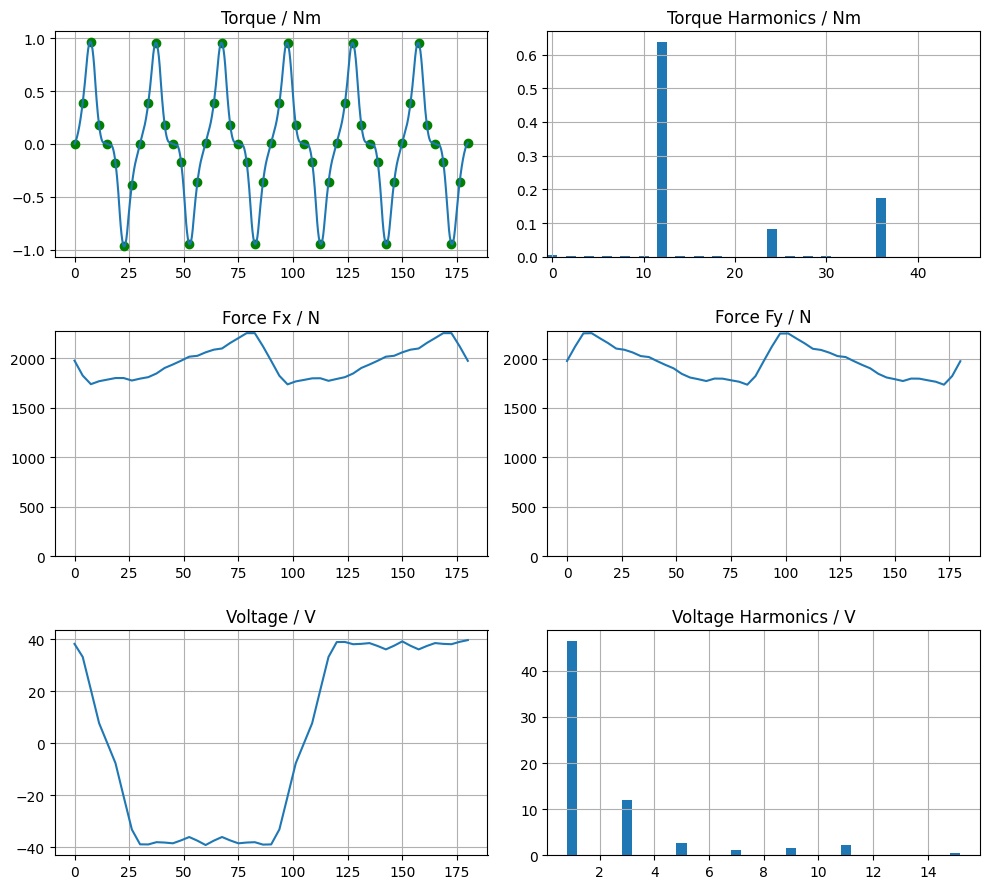

In [7]:
import femagtools.plot
femagtools.plot.cogging(r)

In [8]:
r.current_angles

[210.0, 330.0, 90.0]

In [9]:
machine1['current_angles'] = r.current_angles
num_move_steps = len(r.flux['1'][0]['displ'])-1

Calculate force density without eccentricity

In [10]:
simulation = {
    "angl_i_up": 0.0,
    "calculationMode": "pm_sym_fast",
    "wind_temp": 120.0,
    "magn_temp": 70.0,
    "current": 50,
    "speed": 4000/60,
    "calc_noload": 0,
    "eval_force": 1,
    "num_move_steps": num_move_steps+1,
    "poc":femagtools.poc.Poc(current_angles=machine1['current_angles']),
    "num_par_wdgs": machine1['winding']['num_par_wdgs'],
    'airgap_induc': True
}
r = femag({'name': machine1['name'], 'poles':machine1['poles']}, simulation)

2024-06-09 19:13:40,683 Poc file sin_4p.poc
2024-06-09 19:13:40,693 create simulation 'pm_sym_fast'
2024-06-09 19:13:40,701 invoking /home/tar/bin/xfemag64 -b femag.fsl
2024-06-09 19:13:40,722  > FSL...exe "femag.fsl"
2024-06-09 19:14:09,148  > Load model "IPM-4"Save model and close files
2024-06-09 19:14:09,185  > FSL...halt
2024-06-09 19:14:09,208 /home/tar/bin/xfemag64 exited with returncode 0 (num errs=0)
2024-06-09 19:14:09,209 Read BCH ipm/IPM-4_048.BATCH
2024-06-09 19:14:09,212 flux density: 4 poles B amp 0.770387 


In [11]:
fd0 = femag.read_forcedens()

2024-06-09 19:14:09,216 Read PLT0 ipm/IPM-4_014.PLT0
2024-06-09 19:14:09,227 ipm/IPM-4_014.PLT0 shape (49, 97): pos (0.0, 180.0), FN (-7107.53, 577830.19) position,unit,column_units,X,FN,FT,Radius,B_N,B_T


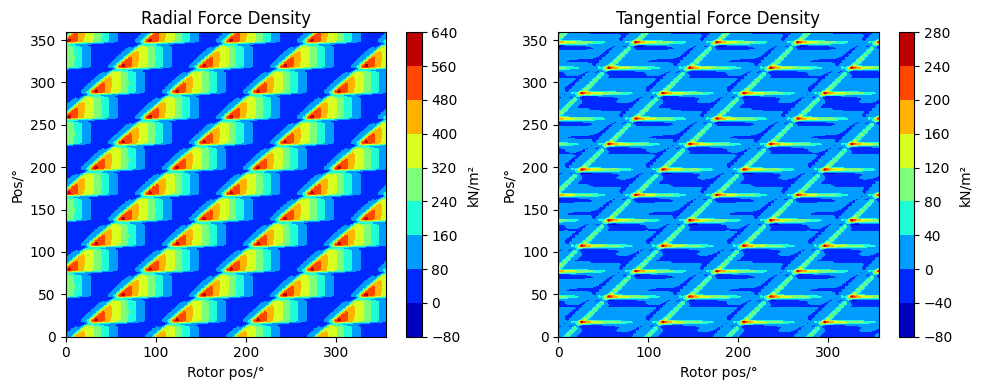

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
femagtools.plot.forcedens_contour(fd0, attr='FN', ax=axs[0])
femagtools.plot.forcedens_contour(fd0, attr='FT', ax=axs[1])
fig.tight_layout()

Build full model (without plots)

In [13]:
machine1['dxffile'] = {'name':'IPM4.dxf', 'full_model':True}
r = femag(machine1)

2024-06-09 19:14:09,684 Copy file M400-50A.MCV
2024-06-09 19:14:09,686 create new model 'IPM-4'
2024-06-09 19:14:09,686 ***** start processing IPM4 *****
2024-06-09 19:14:11,164 total elements 292
2024-06-09 19:14:11,245 check for full machine
2024-06-09 19:14:11,270  - it is full
2024-06-09 19:14:11,527 === airgap is 34.25 ===
2024-06-09 19:14:11,969 *** Begin symmetry search for inner ***
2024-06-09 19:14:12,049  - inner: symmetry axis found
2024-06-09 19:14:12,177 *** End of symmetry search for inner (symmetry and mirror) ***
2024-06-09 19:14:12,177 *** Begin symmetry search for outer ***
2024-06-09 19:14:12,549  - outer: symmetry axis found
2024-06-09 19:14:12,877 *** End of symmetry search for outer (symmetry and mirror) ***
2024-06-09 19:14:13,293 ***** END of work: IPM4 *****
2024-06-09 19:14:13,293 Num nodes/p 96 Num nodes/slot 32 nodedist 1
2024-06-09 19:14:13,455 -- all done in 3.7685 seconds --
2024-06-09 19:14:13,456  num poles 4 num slots 12 outer diameter 0.1300 m
2024-06

In [14]:
r

{'status': 'ok',
 'message': 'IPM-4',
 'model': {'name': 'IPM-4',
  'poles': 4,
  'outer_diam': 0.13000003059029286,
  'airgap': 0.0014999947484759133,
  'bore_diam': 0.06999999565274845,
  'external_rotor': False,
  'agndst': 0.0005604143219056166,
  'stator': {'num_slots': 12, 'num_slots_gen': 12}}}

2024-06-09 19:14:30,572 Total nodes 14938 elements 29223 superelements 79 subregions 14


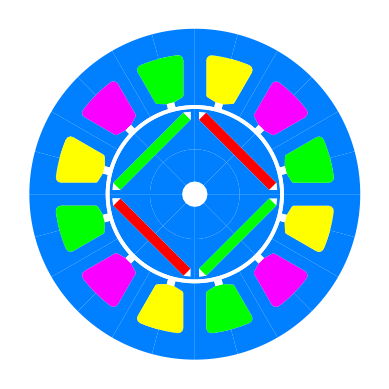

In [15]:
import femagtools.plot
nc = femag.read_nc()
femagtools.plot.spel(nc)

Number of elements in airgap:

In [16]:
da1=machine1['bore_diam']
ag=machine1['airgap']
agndst=machine1['agndst']
np.pi*(da1-ag)/agndst

384.0

In [17]:
num_move_steps = int(np.pi*(da1-ag)/agndst)//machine1['poles']

In [18]:
num_move_steps

96

In [19]:
simulation = {
    "explicit_mode": 1,
    "angl_i_up": 0.0,
    "calculationMode": "pm_sym_fast",
    "wind_temp": 120.0,
    "magn_temp": 70.0,
    "current": 50,
    "speed": 4000/60,
    "calc_noload": 0,
    "eval_force": 1,
    "num_move_steps": num_move_steps+1,
    "poc":femagtools.poc.Poc(current_angles=machine1['current_angles']),
    "range_phi": 180,
    "num_par_wdgs": machine1['winding']['num_par_wdgs'],
    'airgap_induc': True
}
r0 = femag({'name': machine1['name'], 'poles':machine1['poles']}, simulation)

2024-06-09 19:14:31,069 Poc file sin_4p.poc
2024-06-09 19:14:31,081 create simulation 'pm_sym_fast'
2024-06-09 19:14:31,092 invoking /home/tar/bin/xfemag64 -b femag.fsl
2024-06-09 19:14:31,117  > FSL...exe "femag.fsl"
2024-06-09 19:17:48,717  > Load model "IPM-4"Save model and close files
2024-06-09 19:17:48,835  > FSL...halt
2024-06-09 19:17:48,869 /home/tar/bin/xfemag64 exited with returncode 0 (num errs=0)
2024-06-09 19:17:48,870 Read BCH ipm/IPM-4_049.BATCH
2024-06-09 19:17:48,874 flux density: 4 poles B amp 0.770314 


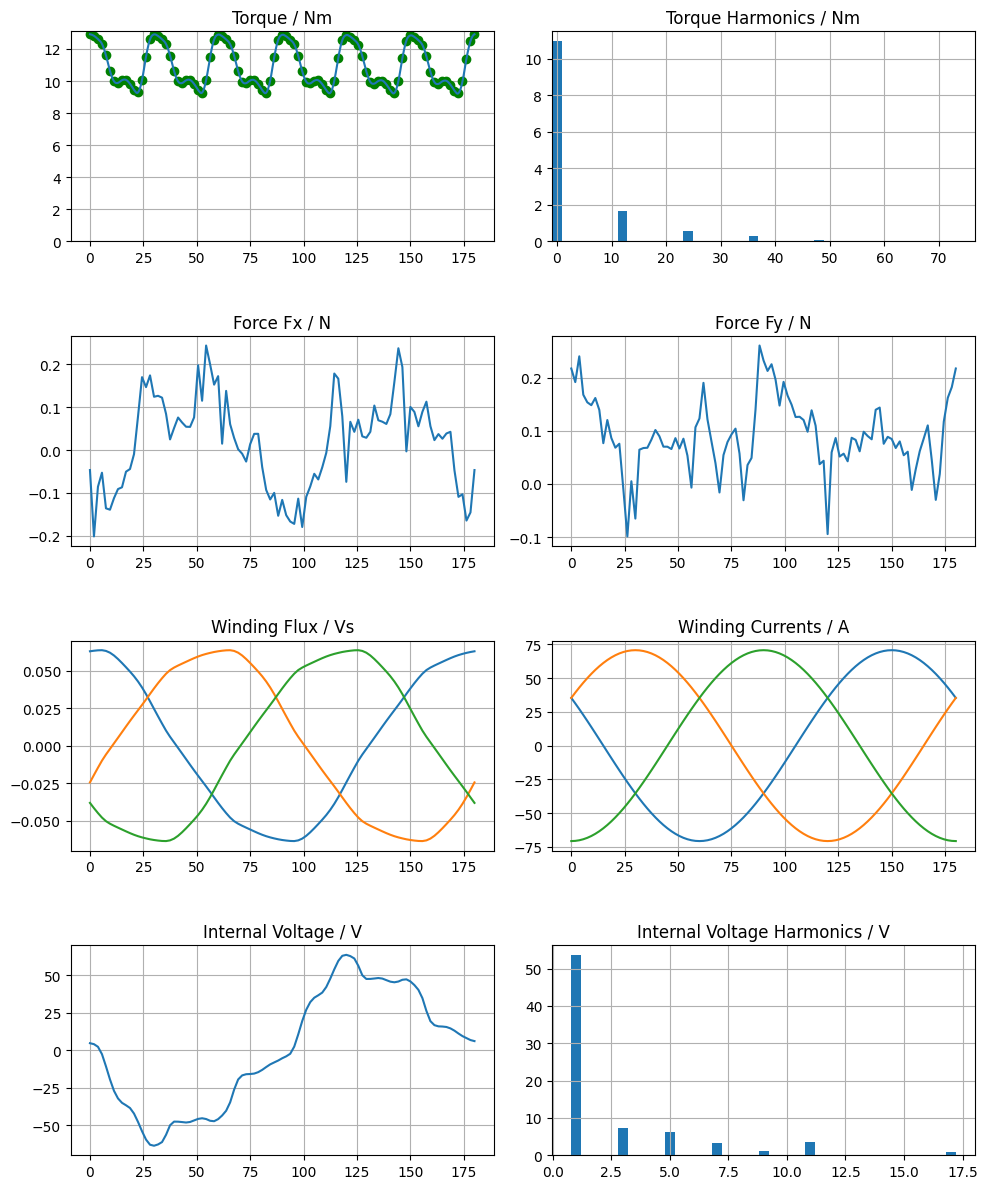

In [20]:
femagtools.plot.pmrelsim(r0)

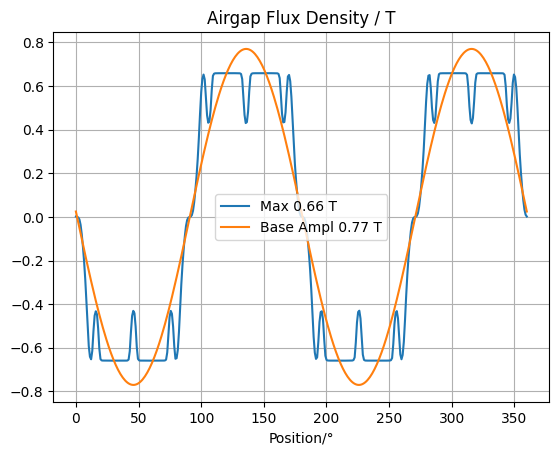

In [21]:
femagtools.plot.airgap(r0.airgap)

2024-06-09 19:17:50,102 Read PLT0 ipm/IPM-4_015.PLT0
2024-06-09 19:17:50,180 ipm/IPM-4_015.PLT0 shape (97, 386): pos (0.0, 180.0), FN (-7434.17, 585186.06) position,unit,column_units,X,FN,FT,Radius,B_N,B_T


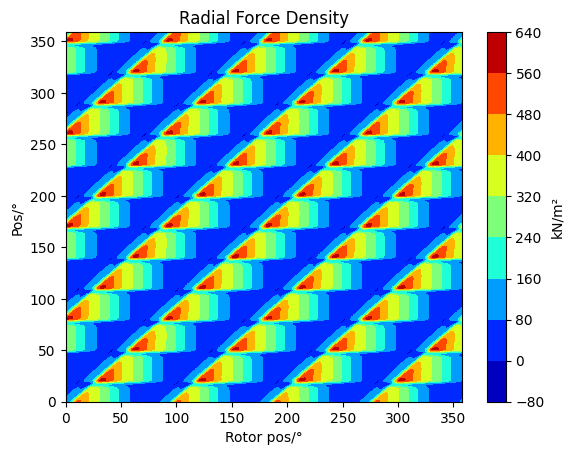

In [22]:
fd1 = femag.read_forcedens()
femagtools.plot.forcedens_contour(fd1)

Check if step distances are equal:

In [23]:
np.diff(r0.flux['1'][0]['displ'])

array([1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875, 1.875,
       1.875, 1.875, 1.875, 1.875, 1.875, 1.875])

Calculate with static eccentricity of 0.4mm:

In [24]:
simulation = {
    "angl_i_up": 0.0,
    "calculationMode": "pm_sym_fast",
    "wind_temp": 120.0,
    "magn_temp": 70.0,
    "current": 50,
    "speed": 4000/60,
    "calc_noload": 0,
    "num_move_steps": num_move_steps+1,
    "poc":femagtools.poc.Poc(current_angles=machine1['current_angles']),
    "eccentricity": {'type':'static', 'bore_diam': machine1['bore_diam'], 
                     'airgap': machine1['airgap'], 'ecc': 0.4e-3},    
    "range_phi": 180,
    "num_par_wdgs": machine1['winding']['num_par_wdgs'],
    'airgap_induc': True
}
r = femag({'name': machine1['name'], 'poles':machine1['poles']}, simulation)

2024-06-09 19:17:50,425 Poc file sin_4p.poc
2024-06-09 19:17:50,439 create simulation 'pm_sym_fast'
2024-06-09 19:17:50,448 invoking /home/tar/bin/xfemag64 -b femag.fsl
2024-06-09 19:17:50,474  > FSL...exe "femag.fsl"
2024-06-09 19:21:07,326  > Load model "IPM-4"Save model and close files
2024-06-09 19:21:07,451  > FSL...halt
2024-06-09 19:21:07,487 /home/tar/bin/xfemag64 exited with returncode 0 (num errs=0)
2024-06-09 19:21:07,488 Read BCH ipm/IPM-4_050.BATCH
2024-06-09 19:21:07,492 flux density: 4 poles B amp 0.770258 


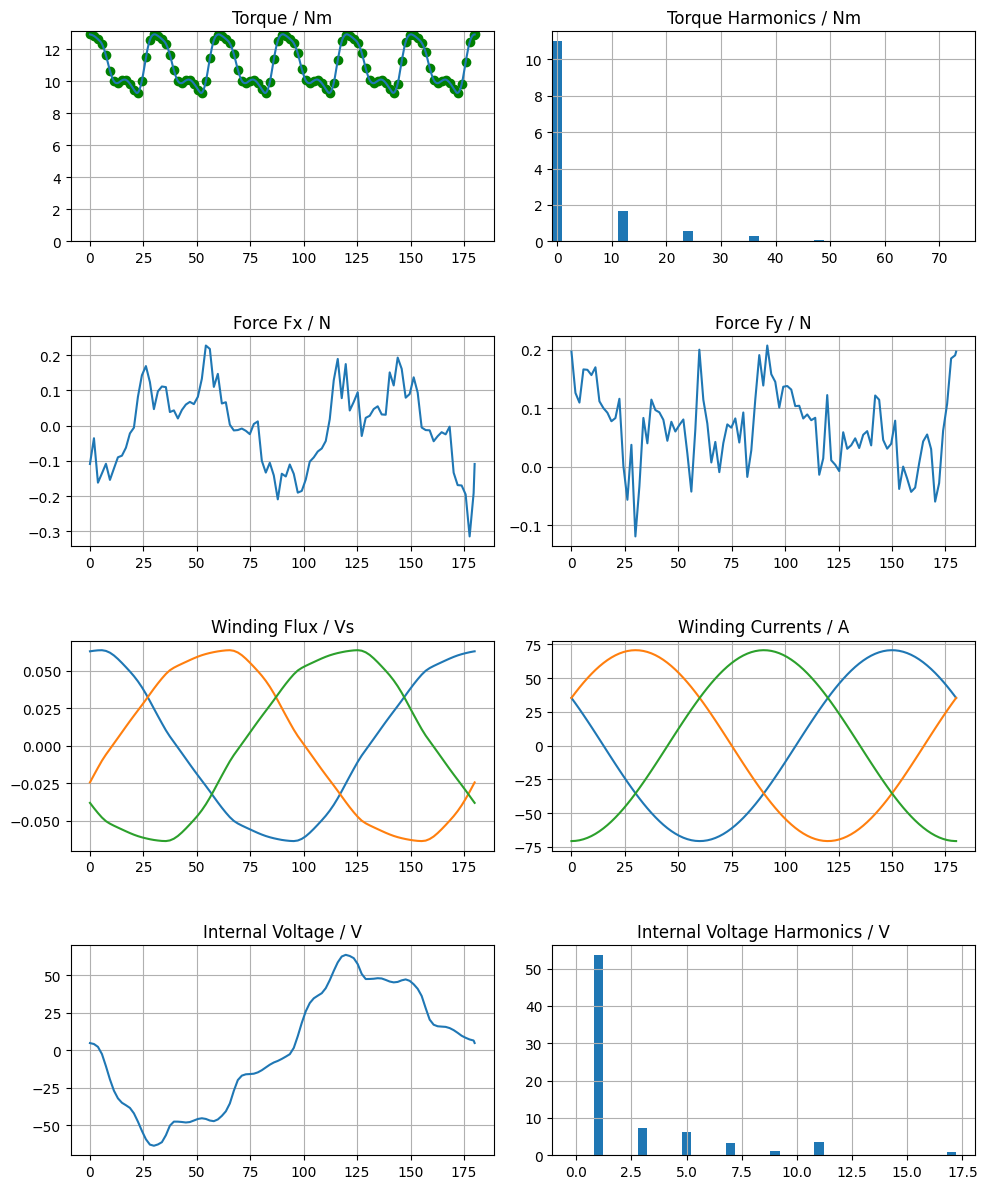

In [25]:
femagtools.plot.pmrelsim(r)

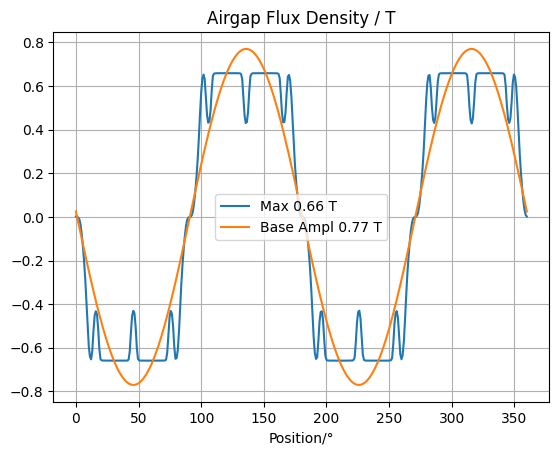

In [26]:
femagtools.plot.airgap(r.airgap)

In [27]:
fd = femag.read_forcedens()

2024-06-09 19:21:08,628 Read PLT0 ipm/IPM-4_015.PLT0
2024-06-09 19:21:08,709 ipm/IPM-4_015.PLT0 shape (97, 386): pos (0.0, 180.0), FN (-7434.17, 585186.06) position,unit,column_units,X,FN,FT,Radius,B_N,B_T


Comparison of force densities without (top) and with eccentricity (bottom)

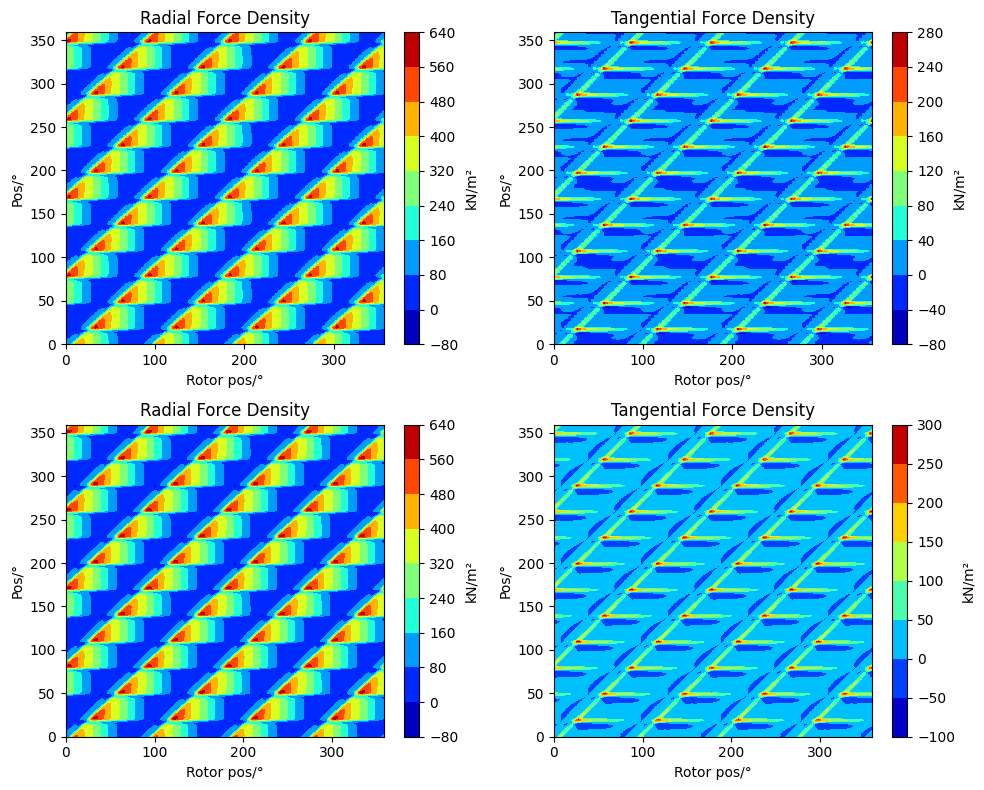

In [28]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,8))
femagtools.plot.forcedens_contour(fd0, attr='FN', ax=axs[0, 0])
femagtools.plot.forcedens_contour(fd0, attr='FT', ax=axs[0, 1])
femagtools.plot.forcedens_contour(fd, attr='FN', ax=axs[1, 0])
femagtools.plot.forcedens_contour(fd, attr='FT', ax=axs[1, 1])
fig.tight_layout()